In [1]:
#PARAMETERS
BATCH_SIZE = 2
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
TRAIN_PERCENTAGE = .8
NUM_CLASSES = 20

In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
import PIL.Image
from matplotlib import pyplot as plt

In [3]:
%%cmd
git clone https://github.com/pytorch/vision.git

Microsoft Windows [Version 10.0.19045.3208]
(c) Microsoft Corporation. Alle Rechte vorbehalten.

(DV-STA) c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN>git clone https://github.com/pytorch/vision.git


fatal: destination path 'vision' already exists and is not an empty directory.



(DV-STA) c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN>

In [4]:
import shutil

#FUNCTIONS ARE MODIFIED DO NOT RUN THIS OR PROGRESS WILL BE LOST!
# shutil.copy("vision/references/detection/utils.py", "./")
# shutil.copy("vision/references/detection/transforms.py", "./")
# shutil.copy("vision/references/detection/coco_eval.py", "./")
# shutil.copy("vision/references/detection/engine.py", "./")
# shutil.copy("vision/references/detection/coco_utils.py", "./")

In [5]:
import cv2
from IPython.display import display, Image

def draw_annotation(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    
    # Extract the annotation details
    filename = annotation["FileName"]
    annotations = annotation["Annotations"]
    
    # Process each annotation
    for annot in annotations:
        bounding_box = annot["BoundingBox"]
        class_name = annot["classname"]
        
        # Draw the bounding box
        x_min, y_min, x_max, y_max = bounding_box
        print(x_min, y_min, x_max, y_max)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Add the class label
        text = f"{class_name}"
        cv2.putText(image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        #make a dot at x_min, y_min and x_max, y_max
        cv2.circle(image, (x_min, y_min), 5, (0, 0, 255), -1)
        cv2.circle(image, (x_max, y_max), 5, (255, 0, 0), -1)
    
    # Save the image with annotations
    annotated_image_path = "annotated_image.jpg"
    cv2.imwrite(annotated_image_path, image)
    
    # Display the image in the notebook
    display(Image(filename=annotated_image_path))


In [6]:
CLASS_LABELS = {
    "hijab_niqab": 0,
    "mask_colorful": 1,
    "mask_surgical": 2,
    "face_no_mask": 3,
    "face_with_mask_incorrect": 4,
    "face_with_mask": 5,
    "face_other_covering": 6,
    "scarf_bandana": 7,
    "balaclava_ski_mask": 8,
    "face_shield": 9,
    "other": 10,
    "gas_mask": 11,
    "turban": 12,
    "helmet": 13,
    "sunglasses": 14,
    "eyeglasses": 15,
    "hair_net": 16,
    "hat": 17,
    "goggles": 18,
    "hood": 19
}

{'FileName': '2006.jpg', 'NumOfAnno': 4, 'Annotations': [{'isProtected': False, 'ID': 280459329561863488, 'BoundingBox': [276, 145, 377, 255], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 239543555427487392, 'BoundingBox': [207, 50, 310, 178], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 442800710251389568, 'BoundingBox': [287, 188, 364, 245], 'classname': 'mask_surgical', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 293325675214463168, 'BoundingBox': [219, 96, 303, 169], 'classname': 'mask_surgical', 'Confidence': 1, 'Attributes': {}}]}
276 145 377 255
207 50 310 178
287 188 364 245
219 96 303 169


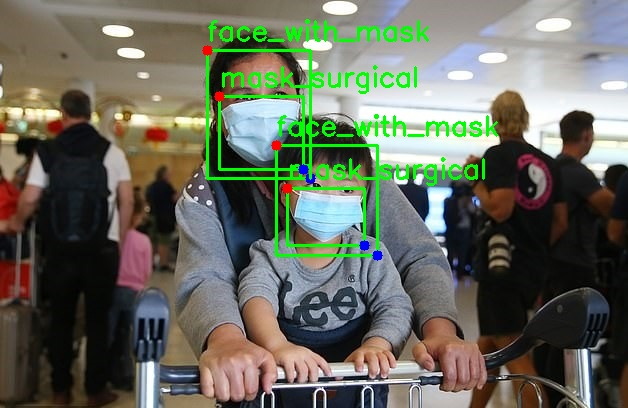

In [7]:
number = 2006


image_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images\\{number}.jpg".format(number=number)

#read json file
import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations\\{number}.jpg.json'.format(number=number)) as json_file:
    annotation = json.load(json_file)

print(annotation)

draw_annotation(image_path, annotation)

In [8]:
#open the json file at Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json

import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json') as json_file:
    meta = json.load(json_file)

#copunt the entries in classes
print(len(meta["classes"]))

20


In [9]:
import os
import PIL.Image as Image

import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
import os
import json
import PIL.Image
import xml.etree.ElementTree as et

class MaskDetectionDataset(Dataset):
    def __init__(self, root_dir, target_size=(600, 900)):
        self.root_dir = root_dir
        self.annotations = []
        self.target_size = target_size
        self.load_annotations()

    def load_annotations(self):
        annotation_files = os.listdir(f"{self.root_dir}/annotations")
        for file_name in annotation_files:
            with open(f"{self.root_dir}/annotations/{file_name}", "r") as f:
                annotation_data = json.load(f)
                annotations = annotation_data["Annotations"]
                file_name = annotation_data["FileName"]
                self.annotations.append((annotations, file_name))
                # Check if the boxes are valid
                for annotation in annotations:
                    boxes = annotation["BoundingBox"]
                    if boxes[0] >= boxes[2] or boxes[1] >= boxes[3]:
                        print("Invalid bounding box coordinates in file:", file_name)
                        break

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotations = self.annotations[idx][0]
        file_name = self.annotations[idx][1]
        image_path = f"{self.root_dir}/images/{file_name}"
        image = PIL.Image.open(image_path).convert("RGB")
        original_image_width, original_image_height = image.size
        image = F.resize(image, self.target_size)
        image = F.to_tensor(image)

        boxes = []
        labels = []
        for annotation in annotations:
            box = annotation["BoundingBox"]
            if box[0] < box[2] and box[1] < box[3]:
                # Resize the bounding box coordinates
                box_resized = [
                    box[0] * self.target_size[0] / original_image_width,
                    box[1] * self.target_size[1] / original_image_height,
                    box[2] * self.target_size[0] / original_image_width,
                    box[3] * self.target_size[1] / original_image_height
                ]
                boxes.append(box_resized)
                class_name = annotation["classname"]
                # Get the class label based on the class name
                class_label = self.get_class_label(class_name)
                labels.append(class_label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])

        return image, target

    
    def get_class_label(self, class_name):
        return CLASS_LABELS.get(class_name, -1)  # Return -1 if class_name is not found






In [22]:
from face_mask_datasets import MaskDetectionDatasetJSON, MaskDetectionDatasetXML

dataset = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask", CLASS_LABELS, (512,512),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
#dataset_singleFaces = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",(512,512))

#dataset_xml = MaskDetectionDatasetXML("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Kaggle Face Mask Detection Full",(512,512))

In [23]:
dataset.__len__()

4326

In [24]:
#dataset_singleFaces.__len__()

In [25]:
# Split the dataset into training and validation sets (adjust the split ratio as needed)
train_size = int(TRAIN_PERCENTAGE * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [26]:
import utils

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=utils.collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=utils.collate_fn)

In [27]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [29]:
# import torch
# from torch.utils.data import DataLoader
# from torchvision.models.detection.roi_heads import fastrcnn_loss

# def calculate_validation_loss(model, data_loader, criterion, device):
#     model.eval()
#     total_loss = 0.0
#     num_samples = 0

#     with torch.no_grad():
#         for batch in data_loader:
#             images = batch['image'].to(device)
#             targets = batch['targets']

#             # Unpack targets dictionary
#             boxes = [target['boxes'].to(device) for target in targets]
#             labels = [target['labels'].to(device) for target in targets]

#             outputs = model(images)

#             # Process model outputs
#             class_logits = [output['scores'] for output in outputs]
#             box_regression = [output['boxes'] for output in outputs]

#             # Calculate the fasterrcnn_loss
#             loss, _ = criterion(torch.cat(class_logits), torch.cat(box_regression), labels, boxes)

#             total_loss += loss.item() * images.size(0)
#             num_samples += images.size(0)

#     validation_loss = total_loss / num_samples
#     return validation_loss


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device

device(type='cuda')

In [31]:
from engine import train_one_epoch, evaluate

# Define empty arrays to collect metrics
ap_values = []
ar_values = []

losses = []

for epoch in range(NUM_EPOCHS):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=1, losses_out=losses)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # adjusted numpy library code for evaluate to work with newer numpy versions
    evaluator = evaluate(model, val_data_loader, device=device)
    #print(evaluator)

    # Extract the metrics from the evaluator
    iou_thresholds = evaluator.coco_eval['bbox'].params.iouThrs
    average_precisions = evaluator.coco_eval['bbox'].stats[:6]
    average_recalls = evaluator.coco_eval['bbox'].stats[6:]

    # Append the metrics to the arrays
    ap_values.append(average_precisions)
    ar_values.append(average_recalls)


Epoch: [0]  [  0/289]  eta: 0:16:39  lr: 0.000022  loss: 3.0844 (3.0844)  loss_classifier: 2.7383 (2.7383)  loss_box_reg: 0.2480 (0.2480)  loss_objectness: 0.0779 (0.0779)  loss_rpn_box_reg: 0.0202 (0.0202)  time: 3.4569  data: 0.1350  max mem: 8561
Epoch: [0]  [  1/289]  eta: 0:10:22  lr: 0.000040  loss: 3.0844 (3.1517)  loss_classifier: 2.7383 (2.7390)  loss_box_reg: 0.2480 (0.2996)  loss_objectness: 0.0779 (0.0882)  loss_rpn_box_reg: 0.0202 (0.0250)  time: 2.1619  data: 0.1335  max mem: 8721
Epoch: [0]  [  2/289]  eta: 0:08:14  lr: 0.000057  loss: 3.2056 (3.1697)  loss_classifier: 2.7383 (2.7335)  loss_box_reg: 0.2766 (0.2919)  loss_objectness: 0.0985 (0.1197)  loss_rpn_box_reg: 0.0238 (0.0246)  time: 1.7246  data: 0.1373  max mem: 8721
Epoch: [0]  [  3/289]  eta: 0:07:21  lr: 0.000074  loss: 3.0844 (3.1202)  loss_classifier: 2.7224 (2.7140)  loss_box_reg: 0.2480 (0.2612)  loss_objectness: 0.0985 (0.1225)  loss_rpn_box_reg: 0.0202 (0.0225)  time: 1.5454  data: 0.1725  max mem: 8721


KeyboardInterrupt: 

In [ ]:
%matplotlib inline

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

: 

In [ ]:
%matplotlib inline

# Convert the arrays to numpy arrays for easier plotting
ap_values = np.array(ap_values)
ar_values = np.array(ar_values)

iou_thresholds_available = ["0.50:0.95", "0.50", "0.75", "0.50:0.95_small", "0.50:0.95_medium", "0.50:0.95_large"]

# Plot the average precisions over epochs
plt.figure(figsize=(10, 5))
for i, iou_thresh in enumerate(iou_thresholds_available):
    plt.plot(ap_values[:, i], label=f"IoU={iou_thresh}")
plt.xlabel("Epochs")
plt.ylabel("Average Precision")
plt.title("Average Precision vs. Epochs")
plt.legend()
plt.show()

# Plot the average recalls over epochs
plt.figure(figsize=(10, 5))
for i, iou_thresh in enumerate(iou_thresholds_available):
    plt.plot(ar_values[:, i], label=f"IoU={iou_thresh}")
plt.xlabel("Epochs")
plt.ylabel("Average Recall")
plt.title("Average Recall vs. Epochs")
plt.legend()
plt.show()

: 

In [ ]:
iter = iter(val_data_loader)

: 

In [ ]:


samples = next(iter)

#get a sample from the samples

sample = samples[0]
image = sample[0]

# model.eval()
# with torch.no_grad():
#     predictions = model(samples[0].to(device))

# prediction
samples

: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image, display

def visualize_prediction2(image, boxes, labels):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image.permute(1, 2, 0))

    # Iterate over all bounding boxes
    for box, label in zip(boxes, labels):
        # Get the coordinates of the bounding box
        x_min, y_min, x_max, y_max = box

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add the class label
        text = f"{label}"
        ax.text(x_min, y_min, text, bbox=dict(facecolor='white', alpha=0.5))

    # Save the plot as an image
    fig.savefig('output.png')

    # Close the figure to free up resources
    plt.close(fig)

    # Display the saved image
    display(Image('output.png'))

# Call the function with your image, bounding boxes, and labels
# visualize_prediction(image, boxes, labels)


: 

In [ ]:
def visualize_prediction(images, model, confidence_threshold, allowed_labels = [3, 4, 5, 6]):
    # Set the model to evaluation mode
    model.eval()
    mean=[0.485, 0.456, 0.406] 
    std=[0.229, 0.224, 0.225]
    # Preprocess the images
    ims = list(image.to(device) for image in images)
    # Perform inference
    with torch.no_grad():
        predictions = model(ims)
        #good = torch.argwhere(scores > confidence_threshold)
        #print(predictions)

    for image, prediction in zip(images, predictions):
        # Convert the image tensor to a PIL Image
        #image_pil = transforms.ToPILImage()(image)

        # Unnormalize the image
        image_pil = transforms.ToPILImage()(image)


        # Get the predicted bounding boxes, labels, and scores
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        # Visualize the image and predicted bounding boxes
        fig, ax = plt.subplots(1)
        ax.imshow(image_pil)

        for box, label, score in zip(boxes, labels, scores):
            if label in allowed_labels and score > confidence_threshold:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                class_name = list(CLASS_LABELS.keys())[list(CLASS_LABELS.values()).index(label)]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{class_name}", color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        plt.show()
    model.train()

: 

In [ ]:
samples[1][0]

: 

In [ ]:
%matplotlib inline

image_pil = transforms.ToPILImage()(samples[0][0])

fig, ax = plt.subplots(1)
ax.imshow(image_pil)
plt.show()


: 

In [ ]:
visualize_prediction(samples[0], model, 0.5, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

: 

In [ ]:
model.eval()
model([image.to(device)])

: 

In [ ]:
dataset.__getitem__(1)

: 

In [ ]:
torch.save(model.state_dict(), "mask_detection_model.pth")


: 

: 